In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")
current_path = os.getcwd()
print("Current Directory path:  "+os.getcwd())
print("subdirectories list:     ", os.listdir())

Current Directory path:  /content/drive/MyDrive/Colab Notebooks
subdirectories list:      ['Refugee-V1-Dataset', 'Old Codes', 'trained_glaucoma_model.h5', 'Google bard - basic model training.ipynb', 'Google bard - basic model training + loss curves.ipynb', 'basic model training.ipynb', 'Basic Model (new learning rate & Epochs + friendlu loss & conf matrix graphs).ipynb', 'variables', 'assets', 'saved_model.pb', 'fingerprint.pb', 'keras_metadata.pb', 'Resnet50_Refugeemodel.h5', 'Resnet50_Refugeemodel.keras', 'Basic Model Augmentation + Gradcam.ipynb', 'Refugee_Cam explainability.ipynb', 'Trying torchcam on my model.ipynb', 'baseline_glaucoma_model.keras', 'Basic Model Training (Sigmoid).ipynb', 'Basic Model (new learning rate & Epochs + friendlu loss & conf matrix graphs) + Augmentation.ipynb', 'model2_Augmentation introduced.ipynb', 'model3_Augmentation introduced.ipynb']


In [ ]:
current_path

'/content/drive/MyDrive/Colab Notebooks'

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import scipy.ndimage as ndimage


In [ ]:
# Define paths to training images and labels
glaucoma_images_path = "/content/drive/MyDrive/Colab Notebooks/Refugee-V1-Dataset/Glaucoma 800"
non_glaucoma_images_path = "/content/drive/MyDrive/Colab Notebooks/Refugee-V1-Dataset/Non Glaucoma 800"
Testing_images = "Refugee-V1-Dataset/Test400"
Augmented_images_path = "/content/drive/MyDrive/Colab Notebooks/Refugee-V1-Dataset/Aug400"

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
import numpy as np
import os
from PIL import Image

In [ ]:
# Preprocess training images and labels
def load_data(image_path, is_glaucoma):
    """
    Loads and pre-processes a retinal fundus image.

    Args:
    image_path: Path to the retinal fundus image.
    is_glaucoma: Boolean flag indicating whether the image belongs to the glaucoma class.

    Returns:
    preprocessed_image: Pre-processed image as a NumPy array.
    label: Integer label representing the image class (0 for non-glaucoma, 1 for glaucoma).
    """
    # Load image
    image = Image.open(image_path).convert("RGB")
    # Resize image to 224x224
    resized_image = image.resize((224, 224))
    # Convert image to NumPy array
    image_array = np.array(resized_image)
    # Normalize pixel values
    normalized_image = image_array / 255.0

    # Convert color channel order to channels_first if needed
    # (optional based on your model's format)
    # if normalized_image.shape[2] == 3:
    #   normalized_image = np.moveaxis(normalized_image, 2, 0)

    # Assign label based on glaucoma class
    label = 1 if is_glaucoma else 0
    return normalized_image, label

Sample glaucoma image: (224, 224, 3)
Glaucoma label: 1


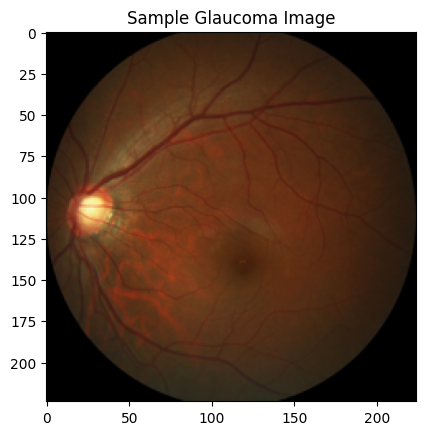

In [ ]:
# Load and display a sample image from Galucoma class
os.chdir(glaucoma_images_path)
glaucoma_image, glaucoma_label = load_data(os.listdir()[10], True)
print(f"Sample glaucoma image: {glaucoma_image.shape}")
print(f"Glaucoma label: {glaucoma_label}")
plt.figure()
plt.imshow(glaucoma_image)
plt.title("Sample Glaucoma Image")
plt.show()

Sample non-glaucoma image: (224, 224, 3)
Non-glaucoma label: 0


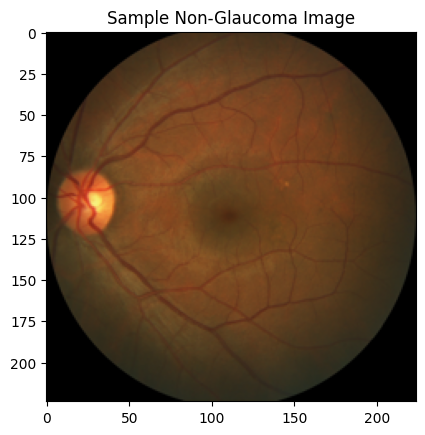

In [ ]:
# Load and display a sample image from Non-Galucoma class
os.chdir(non_glaucoma_images_path)
non_glaucoma_image, non_glaucoma_label = load_data(os.listdir()[10], False)
print(f"Sample non-glaucoma image: {non_glaucoma_image.shape}")
print(f"Non-glaucoma label: {non_glaucoma_label}")
plt.figure()
plt.imshow(non_glaucoma_image)
plt.title("Sample Non-Glaucoma Image")
plt.show()

Sample Augmented glaucoma image: (224, 224, 3)
Glaucoma label: 1


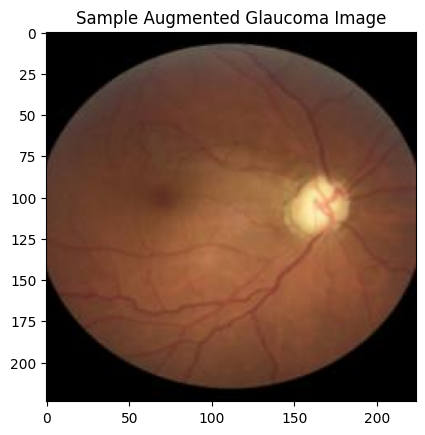

Sample Augmented glaucoma image: (224, 224, 3)
Glaucoma label: 1


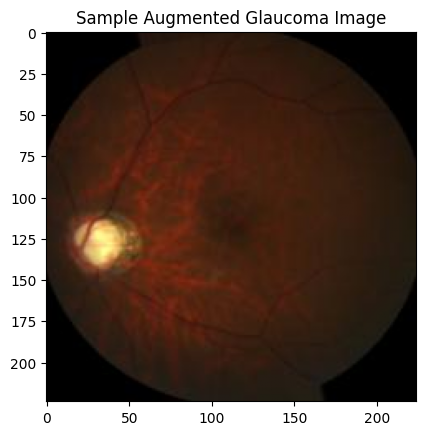

Sample Augmented glaucoma image: (224, 224, 3)
Glaucoma label: 1


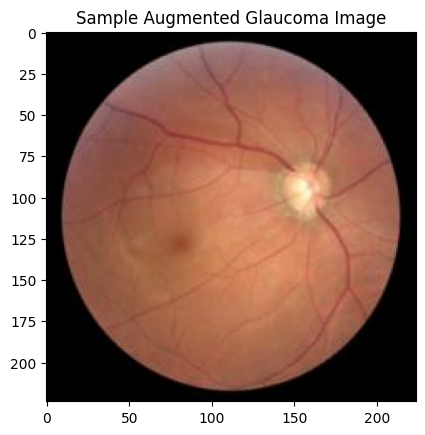

Sample Augmented glaucoma image: (224, 224, 3)
Glaucoma label: 1


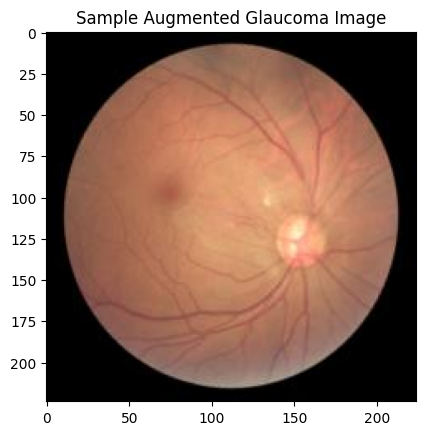

In [ ]:
# Load and display a sample image from Augmentation sample
os.chdir(Augmented_images_path)
for i in range(4):
    glaucoma_image, glaucoma_label = load_data(os.listdir()[i], True)
    print(f"Sample Augmented glaucoma image: {glaucoma_image.shape}")
    print(f"Glaucoma label: {glaucoma_label}")
    plt.figure()
    plt.imshow(glaucoma_image)
    plt.title("Sample Augmented Glaucoma Image")
    plt.show()

In [ ]:
glaucoma_images, glaucoma_labels = [], []
for image_path in os.listdir(glaucoma_images_path):
    image, label = load_data(os.path.join(glaucoma_images_path, image_path), True)
    glaucoma_images.append(image)
    glaucoma_labels.append(label)

for image_path in os.listdir(Augmented_images_path):
    image, label = load_data(os.path.join(Augmented_images_path, image_path), True)
    glaucoma_images.append(image)
    glaucoma_labels.append(label)

non_glaucoma_images, non_glaucoma_labels = [], []
for image_path in os.listdir(non_glaucoma_images_path):
    image, label = load_data(os.path.join(non_glaucoma_images_path, image_path), False)
    non_glaucoma_images.append(image)
    non_glaucoma_labels.append(label)

# Combine data from both classes
combined_images = np.concatenate((glaucoma_images, non_glaucoma_images))
combined_labels = np.concatenate((glaucoma_labels, non_glaucoma_labels))

# Split data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(combined_images, combined_labels, test_size=0.15, random_state=42)

# Pre-process training and validation images for ResNet50
train_images = preprocess_input(train_images)
val_images = preprocess_input(val_images)

In [ ]:
print("Training images array shape: ",np.shape(train_images))
print("Validation images array shape: ",np.shape(val_images))

Training images array shape:  (1113, 224, 224, 3)
Validation images array shape:  (197, 224, 224, 3)


In [ ]:
# Import additional libraries for heatmap and line plot
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping

# Create ResNet50 model and freeze all but last 2 layers
resnet_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
for layer in resnet_model.layers[:-20]:
    layer.trainable = False

# Add global average pooling and dense layers for classification
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation="sigmoid")(x)

callback = EarlyStopping(monitor='loss',patience=3)
# Create model and compile with Adam optimizer, learning rate, and binary cross-entropy loss
model = Model(inputs=resnet_model.input, outputs=predictions)
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=['accuracy', 'mse'])

# Train model on training data and evaluate on validation data
history = model.fit(
    train_images,
    train_labels,
    epochs=35,  # Increased to 35 epochs
    batch_size=32,
    validation_data=(val_images, val_labels),
    callbacks=callback
)


# Evaluate model and generate confusion matrix on validation data
predictions = model.predict(val_images)
predicted_labels = np.round(predictions)
confusion_matrix = confusion_matrix(val_labels, predicted_labels)



94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/35
35/35 [==============================] - 23s 289ms/step - loss: 0.3883 - accuracy: 0.8248 - mse: 0.1241 - val_loss: 0.6839 - val_accuracy: 0.5533 - val_mse: 0.2454
Epoch 2/35
35/35 [==============================] - 5s 133ms/step - loss: 0.2591 - accuracy: 0.8931 - mse: 0.0777 - val_loss: 0.6831 - val_accuracy: 0.5533 - val_mse: 0.2452
Epoch 3/35
35/35 [==============================] - 5s 132ms/step - loss: 0.2116 - accuracy: 0.9218 - mse: 0.0612 - val_loss: 0.7346 - val_accuracy: 0.5533 - val_mse: 0.2685
Epoch 4/35
35/35 [==============================] - 4s 129ms/step - loss: 0.1893 - accuracy: 0.9335 - mse: 0.0534 - val_loss: 0.7664 - val_accuracy: 0.5533 - val_mse: 0.2814
Epoch 5/35
35/35 [==============================] - 5s 134ms/step - loss: 0.1474 - accuracy: 0.9515 - mse: 0.0409 - val_loss: 0.8440 - val_accuracy: 0.5533 - val_mse: 0.3084
Epoch 6/35
35/35 [==============================] - 5s 133ms/ste

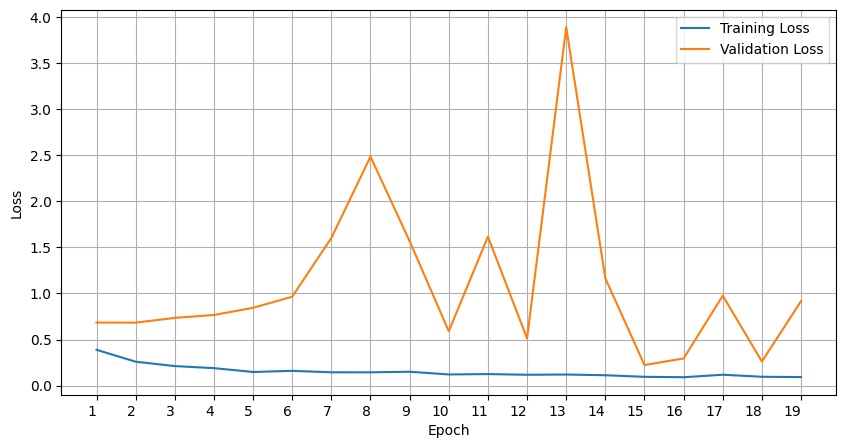

In [ ]:
# Import numpy for range generation
import numpy as np

# Extract the epoch numbers
epochs = np.arange(len(history.history["loss"]))

# Plot train and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history["loss"], label="Training Loss")
plt.plot(epochs, history.history["val_loss"], label="Validation Loss")
plt.xticks(np.arange(len(history.history["loss"])), epochs+1, ha="right")#,rotation=45,)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

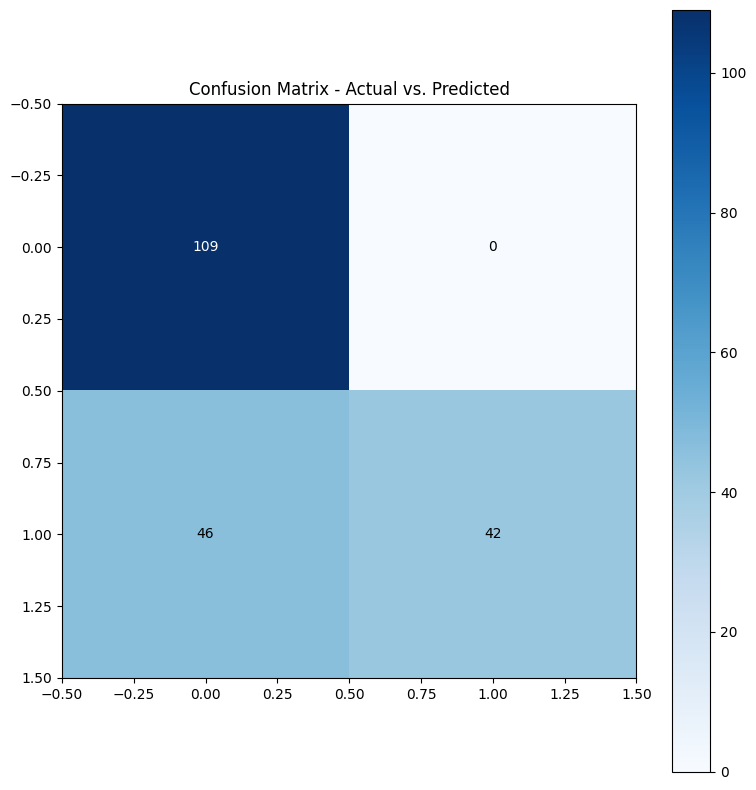

7/7 [==============================] - 1s 90ms/step - loss: 0.9167 - accuracy: 0.7665 - mse: 0.1791
Metrics on validation data: 
 [0.916656494140625, 0.7664974331855774, 0.17907455563545227]


In [ ]:
import itertools # Create heatmap for confusion matrix
def plot_confusion_matrix(cm, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(cm.labels))
    #plt.xticks(tick_marks, cm.labels, rotation=45, ha="right")
    #plt.yticks(tick_marks, cm.labels)
    plt.grid(False)
    fmt = ".2f"  # Adjust format string for desired precision
    thresh = cm.max() / 2.  # Set threshold for color intensity
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] > thresh:
            plt.text(j, i, "{}".format(cm[i, j], fmt), ha="center", va="center", color="white")
        else:
            plt.text(j, i, "{}".format(cm[i, j], fmt), ha="center", va="center", color="black")
    plt.tight_layout()
    plt.show()

# Display confusion matrix as heatmap with class labels
plot_confusion_matrix(confusion_matrix, title="Confusion Matrix - Actual vs. Predicted")

print(f"Metrics on validation data: \n {model.evaluate(val_images, val_labels)}")


In [ ]:
# Save the trained model
model_path = "/content/drive/MyDrive/Colab Notebooks/"
os.chdir(model_path)
model.save("model3_glaucoma_augmentation.keras")

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          